### Breakdown of extra classes
- LeNet: Main code that implements a normal CNN(LeNet)
- Data: Holds DiffractionDataset, which is a subclass of the PyTorch 'Dataset' class, basically just turns our tensors(data) into useable values that we can throw into models and do distributed training

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas
from collections import OrderedDict
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error

import os
from datetime import datetime
import math

#Our Own Created Classes
from LeNet import LeNet
from Data import DiffractionDataset

# Step 1: Load and Analyze Data

### Load and AnalyzeTraining Data

In [2]:
TrainingData = torch.load("100k_COD_TrainTensor.pt") #dict with diffraction patterns and space group

In [3]:
data = TrainingData['X'] 
labels = TrainingData['Y']

In [4]:
labels.shape #number of entires for train/val

torch.Size([37635])

The next module shows the distribution of every bravais lattice, and shows the sad reality of scientific data -- a label imbalance 

Text(0.5, 1.0, 'Distribution of labels')

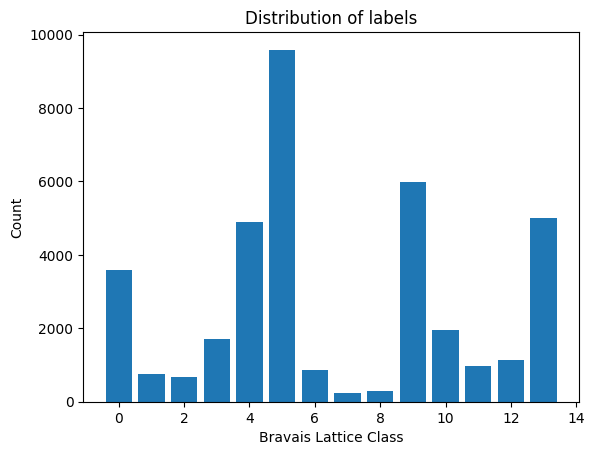

In [5]:
unique_values, counts = torch.unique(labels, return_counts=True)
plt.bar(unique_values.numpy(), counts.numpy())
plt.xlabel("Bravais Lattice Class")
plt.ylabel("Count")
plt.title("Distribution of labels")

### Create Validation Set
- The purpose of a validation set is used to analyze our model's preformance on data that it hasnt trained on
- We use the test set as a "final" metric

In [6]:
data_np = data.numpy()
labels_np = labels.numpy()
nptrainx, npvalx, nptrainy, npvaly = train_test_split( data_np, labels_np, test_size=0.05, random_state=42)

validation_data = torch.from_numpy(npvalx)
validation_labels = torch.from_numpy(npvaly)
train_data = torch.from_numpy(nptrainx)
train_labels = torch.from_numpy(nptrainy)
print("Train Shape:", train_labels.shape)
print("Val Shape:", validation_labels.shape)

Train Shape: torch.Size([35753])
Val Shape: torch.Size([1882])


In [12]:
train_data.shape

torch.Size([35753, 3041])

# Step 2: Train the Models
Define Hyperparmeters, put the model together, train it, and then repeat until the model's preformance looks good


In [13]:
learning_rate = 0.5e-3
epochs = 2
batch_size = 500
input_size = 3041
num_classes = 14

In [15]:
model = LeNet(input_size, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-5)
crossentropy_loss_function = torch.nn.CrossEntropyLoss()

In [16]:
train_dataset = DiffractionDataset(num_classes, 1e-3, train_data, labels=train_labels, unsupervised=False, categorical='Bravais Lattice')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

validation_dataset = DiffractionDataset(num_classes, 1e-3, validation_data, labels = validation_labels, unsupervised=False, categorical='Bravais Lattice')       
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)


Attempting to load data
Attempting to load data


In [17]:
start = datetime.now()
for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    # Training Loop
    i = 0
    for imgs, labels in train_loader:
        i+=1
        optimizer.zero_grad()
        logits = model(imgs) #Compute Predictions
        loss = crossentropy_loss_function(logits, labels) #Compute Loss
        loss.backward() #Update Model
        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels).float().mean().item()
        total_loss += loss.item()
        total_correct += (logits.argmax(dim=-1) == labels).sum().item()
        total_samples += labels.size(0)
        print("[Epoch %d/%d] [%d] [SD loss: %.2f  acc: %d%%]"% (epoch+1, epochs, i, loss.item(), 100 * acc))


    train_acc = total_correct / total_samples * 100
    print(f"Epoch {epoch+1} Training Accuracy: {train_acc:.2f}%")


    model.eval()
    total_correct, total_samples = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            logits = model(imgs)
            total_correct += (logits.argmax(dim=-1) == labels).sum().item()
            total_samples += labels.size(0)

    val_acc = total_correct / total_samples * 100
    print(f"[Epoch %d/%d] [Training Loss: %d%%  Validation Loss: %d%%] " % (epoch+1, epochs, (train_acc),(val_acc)))
totalTime = datetime.now() - start
print(f"Total Train Time: {totalTime}")
#torch.save({'model': model.state_dict(),'optimizer': optimizer.state_dict()}, model_path)


[Epoch 1/2] [1] [SD loss: 2.62  acc: 25%]
[Epoch 1/2] [2] [SD loss: 2.53  acc: 16%]
[Epoch 1/2] [3] [SD loss: 2.47  acc: 25%]
[Epoch 1/2] [4] [SD loss: 2.36  acc: 25%]
[Epoch 1/2] [5] [SD loss: 2.38  acc: 26%]
[Epoch 1/2] [6] [SD loss: 2.36  acc: 25%]
[Epoch 1/2] [7] [SD loss: 2.27  acc: 28%]
[Epoch 1/2] [8] [SD loss: 2.39  acc: 21%]
[Epoch 1/2] [9] [SD loss: 2.27  acc: 25%]
[Epoch 1/2] [10] [SD loss: 2.31  acc: 26%]
[Epoch 1/2] [11] [SD loss: 2.24  acc: 28%]
[Epoch 1/2] [12] [SD loss: 2.21  acc: 23%]
[Epoch 1/2] [13] [SD loss: 2.26  acc: 25%]
[Epoch 1/2] [14] [SD loss: 2.22  acc: 25%]
[Epoch 1/2] [15] [SD loss: 2.23  acc: 26%]
[Epoch 1/2] [16] [SD loss: 2.22  acc: 24%]
[Epoch 1/2] [17] [SD loss: 2.20  acc: 25%]
[Epoch 1/2] [18] [SD loss: 2.23  acc: 22%]
[Epoch 1/2] [19] [SD loss: 2.22  acc: 23%]
[Epoch 1/2] [20] [SD loss: 2.14  acc: 26%]
[Epoch 1/2] [21] [SD loss: 2.21  acc: 23%]
[Epoch 1/2] [22] [SD loss: 2.23  acc: 25%]
[Epoch 1/2] [23] [SD loss: 2.17  acc: 26%]
[Epoch 1/2] [24] [SD

# Step 3: Analyze Model Results

Now its time to grab our test tensor, and look at how our model did. While we could go back and re-train our model to get better results, its common practice in ML to not do this.

Attempting to load data
RMSE: 4.5340


<Figure size 1000x800 with 0 Axes>

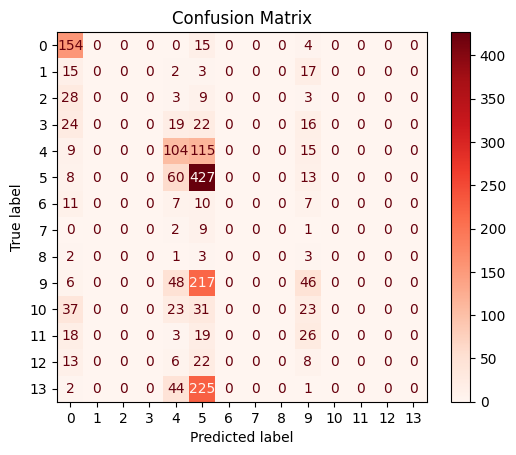

In [22]:
test = torch.load("100k_COD_TestTensor.pt")
test_dataset = DiffractionDataset(num_classes, 1e-3, test['X'], labels=test['Y'], unsupervised=False, categorical='Bravais Lattice')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)
model.eval()
listofpreds = []
listoflabels = []

count = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        count+=1
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)
        if(count == 1):
            print("Sample Output from model: ")
            print(outputs)
            print("After running through argmax: ")
            print(predictions)
        listofpreds.extend(predictions)
        listoflabels.extend(labels)

rmse = np.sqrt(mean_squared_error(listoflabels, listofpreds))
print(f"RMSE: {rmse:.4f}")

conf_matrix = confusion_matrix(listoflabels, listofpreds)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Reds, values_format='d')
plt.title("Confusion Matrix for bravais lattice")
plt.show()